XGBoost to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190705-084937'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=True)

In [3]:
param_dist = {
    'max_depth': sp.stats.randint(1, 8),
    'learning_rate': sp.stats.uniform(0.0005, 0.5),
    'gamma': sp.stats.uniform(0, 1),
    'min_child_weight': sp.stats.randint(1, 15),
    'subsample': sp.stats.uniform(0.7, 0.3),
    'colsample_bytree': sp.stats.uniform(0.4, 0.6),
    'colsample_bylevel': sp.stats.uniform(0.4, 0.6),
    'reg_alpha': sp.stats.expon(0, 20),
    'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2013-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

predictions = {}
actuals = {}
models = {}
for station in station_data_dict.keys():
    print(station)
    station_data = station_data_dict[station]
    
    station_train = station_data.loc[train_start : train_end].copy()
    num_validation_samples = int(validation_fraction * station_train.shape[0])
    shuffle_indices = np.arange(station_train.shape[0])
    np.random.shuffle(shuffle_indices)
    station_train = station_train.iloc[shuffle_indices]
    station_val, station_train = station_train.iloc[:num_validation_samples].copy(), station_train.iloc[num_validation_samples:].copy()
    
    station_test = station_data.loc[test_start : test_end]
    print('Shapes: train {}, val {}, test {}'.format(station_train.shape, station_val.shape, station_test.shape))

    station_val = [(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff']), 
                   (station_val.drop(['station', 'runoff'], axis=1), station_val['runoff'])]
    
    xgb_model = xgb.XGBRegressor(n_estimators=1000, n_jobs=-1, random_state=123)
    m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=1000, cv=3, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1, random_state=123, verbose=5)
    m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'], eval_set=station_val, eval_metric='rmse', early_stopping_rounds=100, verbose=False)
    
    cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
    print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
    print('Best params: {}'.format(m.best_params_))
    print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])
    
    station_test = station_test[~pd.isna(station_test['runoff'])]
    if len(station_test) == 0:
        print('Skipping', station)
        continue

    predict = pd.DataFrame(index=station_test.index)
    predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
    predict['runoff'] = np.nan
    predict['runoff'] = m.predict(predict.drop('runoff', axis=1))

    predictions[station] = predict[['runoff']]
    actuals[station] = station_test['runoff']
    models[station] = m

02GA010
Shapes: train (1308, 1646), val (145, 1646), test (365, 1646)
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 19.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
487                0.408873               0.510453    0.454204   
828                0.550193               0.471905   0.0325992   
878                0.559511               0.461935    0.988931   
258                0.858813               0.861561    0.921226   
807                0.534396               0.411482    0.439208   

    param_learning_rate param_max_depth param_min_child_weight  \
487            0.265851               7                     11   
828             0.28422               3                     14   
878           0.0900973               7                     13   
258            0.168927               3                      6   
807             0.18424               2                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
487         25.2206          15.3364        0.880163      -177.566297   
828        0.436162           45.988        0.853171      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
528                0.402665               0.484791    0.389887   
188                0.519597               0.562186    0.897303   
778                0.565621                0.73908    0.340173   
605                0.730034               0.940146    0.239294   
474                 0.69314               0.405035    0.178761   

    param_learning_rate param_max_depth param_min_child_weight  \
528           0.0229117               4                      1   
188           0.0551259               4                      3   
778            0.150131               2                      3   
605            0.216704               3                      3   
474           0.0650908               3                     13   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
528         14.4564          19.0234        0.772747       -86.140497   
188         18.7579          3.18025        0.871764       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
720                0.556013               0.792499    0.160961   
351                0.461375               0.973289     0.14143   
188                0.519597               0.562186    0.897303   
327                0.747414               0.887742    0.150078   
239                0.758659               0.870249     0.26401   

    param_learning_rate param_max_depth param_min_child_weight  \
720            0.025658               6                      9   
351            0.145873               5                      3   
188           0.0551259               4                      3   
327            0.180564               2                      6   
239           0.0659127               4                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
720         40.2459          1.60956        0.862695       -57.697920   
351         12.6808          7.43757        0.996552       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 22.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
440                0.613756               0.553488    0.251399   
261                0.747597               0.810764    0.976776   
361                0.562596               0.643391    0.342137   
970                0.706535               0.698438    0.639192   
650                0.642457               0.855554    0.667817   

    param_learning_rate param_max_depth param_min_child_weight  \
440            0.159226               2                      3   
261           0.0438398               3                      5   
361           0.0313684               3                     14   
970            0.028734               2                     14   
650           0.0709069               2                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
440           17.43          21.6771        0.707119       -31.150426   
261         22.9608          29.4737        0.780904       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 60.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 73.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 94.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
361                0.562596               0.643391    0.342137   
160                0.533074               0.506938    0.463975   
544                0.738344                0.75687    0.310562   
496                0.403206               0.952049    0.971255   
261                0.747597               0.810764    0.976776   

    param_learning_rate param_max_depth param_min_child_weight  \
361           0.0313684               3                     14   
160            0.146983               2                      1   
544           0.0448832               2                      6   
496            0.117535               2                      1   
261           0.0438398               3                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
361         2.76313          11.4395        0.788409     -2124.733975   
160         37.5946          71.2657        0.749302     -21

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
393                0.857186               0.924186    0.282732   
416                0.792472               0.614149    0.843413   
153                0.939975               0.825785    0.528818   
290                0.446077               0.543665    0.892572   
999                0.917596               0.575961    0.382414   

    param_learning_rate param_max_depth param_min_child_weight  \
393            0.109912               3                     13   
416           0.0288661               3                      4   
153           0.0275494               6                      2   
290           0.0159229               6                     13   
999            0.138932               4                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
393         16.3985          8.51981        0.839281       -14.799337   
416         1.64138          3.80913        0.854644       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
53                 0.434562               0.631493    0.733229   
857                0.448691               0.482916    0.261012   
544                0.738344                0.75687    0.310562   
631                0.770465               0.560365    0.557289   
272                0.442262               0.586112    0.881402   

    param_learning_rate param_max_depth param_min_child_weight  \
53            0.0684254               2                      1   
857            0.149319               2                      3   
544           0.0448832               2                      6   
631            0.145192               2                      2   
272            0.211752               7                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
53          61.5035          2.17131        0.887563       -57.553208   
857         16.7292          14.2266        0.829494       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 34.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
49                 0.591887               0.988301    0.156558   
650                0.642457               0.855554    0.667817   
416                0.792472               0.614149    0.843413   
361                0.562596               0.643391    0.342137   
778                0.565621                0.73908    0.340173   

    param_learning_rate param_max_depth param_min_child_weight  \
49             0.102632               2                     10   
650           0.0709069               2                      6   
416           0.0288661               3                      4   
361           0.0313684               3                     14   
778            0.150131               2                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
49          12.9954          1.40297        0.857238       -11.386814   
650         15.2017          8.02298        0.830693       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 12.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
771                0.421474               0.426353    0.531342   
438                0.591077               0.685277    0.477479   
290                0.446077               0.543665    0.892572   
157                0.990155               0.567304    0.101912   
799                 0.43933               0.951868    0.280325   

    param_learning_rate param_max_depth param_min_child_weight  \
771            0.262061               2                     11   
438           0.0171959               6                      9   
290           0.0159229               6                     13   
157            0.146573               3                      7   
799            0.131242               7                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
771         22.0799          6.46285        0.797654       -22.367504   
438         19.2088          4.09495         0.75852       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 16.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
650                0.642457               0.855554    0.667817   
756                0.690181               0.575484    0.164062   
738                0.477317               0.416395    0.333604   
645                0.501446               0.933008    0.887647   
201                0.569232               0.533621    0.738389   

    param_learning_rate param_max_depth param_min_child_weight  \
650           0.0709069               2                      6   
756            0.127725               3                      9   
738            0.317084               2                     11   
645           0.0801224               3                     14   
201            0.207096               2                     11   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
650         15.2017          8.02298        0.830693       -37.585507   
756         11.3526          60.9482         0.78603       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 21.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
813                0.460739               0.559693    0.848938   
346                0.949186               0.596089    0.195221   
37                 0.723671                0.44826    0.566347   
53                 0.434562               0.631493    0.733229   
544                0.738344                0.75687    0.310562   

    param_learning_rate param_max_depth param_min_child_weight  \
813            0.186383               3                      3   
346            0.157031               2                     14   
37             0.181742               2                     12   
53            0.0684254               2                      1   
544           0.0448832               2                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
813         2.42473          23.4065        0.769794       -51.398683   
346         15.7567            17.87        0.878116       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
481                0.728364               0.454441    0.606986   
488                0.591593               0.519173    0.796693   
600                0.406488               0.827905    0.854839   
58                 0.609711               0.566454    0.998918   
322                 0.54595               0.727617   0.0516954   

    param_learning_rate param_max_depth param_min_child_weight  \
481           0.0869274               3                     12   
488            0.177023               3                      3   
600            0.138598               3                      8   
58            0.0208081               3                     13   
322            0.137391               2                      7   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
481         9.23531          27.0553        0.757473       -20.502870   
488         42.8639          19.8646        0.771575       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  7.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
502                 0.87837               0.727096     0.59956   
595                0.479489               0.492719    0.364028   
521                0.901039               0.835501    0.324206   
243                0.468902               0.672963    0.957804   
175                0.842792               0.422413    0.804882   

    param_learning_rate param_max_depth param_min_child_weight  \
502            0.173053               2                      2   
595           0.0468124               2                      1   
521            0.437903               1                      1   
243              0.3446               2                      2   
175            0.433122               2                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
502         2.03016          2.52547        0.909141       -15.260001   
595         2.16514         0.317428        0.818003       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
801                0.816185               0.572054    0.867051   
253                0.818166               0.478179    0.972714   
894                 0.92354               0.613436    0.417699   
145                0.460033               0.402031    0.285074   
449                0.806723               0.885041    0.289451   

    param_learning_rate param_max_depth param_min_child_weight  \
801            0.118466               3                      2   
253           0.0572363               4                      8   
894           0.0432038               4                     12   
145           0.0826034               5                     11   
449            0.116999               5                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
801         30.5741          94.2402        0.902748      -102.430203   
253         4.68972          39.1362        0.771523      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 35.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
53                 0.434562               0.631493    0.733229   
894                 0.92354               0.613436    0.417699   
474                 0.69314               0.405035    0.178761   
650                0.642457               0.855554    0.667817   
857                0.448691               0.482916    0.261012   

    param_learning_rate param_max_depth param_min_child_weight  \
53            0.0684254               2                      1   
894           0.0432038               4                     12   
474           0.0650908               3                     13   
650           0.0709069               2                      6   
857            0.149319               2                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
53          61.5035          2.17131        0.887563      -227.280271   
894         66.6068          8.61315        0.710674      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
207                0.552134               0.724503    0.127207   
408                0.994688               0.714771    0.596268   
734                0.781567               0.667173    0.242889   
661                0.488336               0.492771    0.855693   
798                0.897709               0.828937    0.438312   

    param_learning_rate param_max_depth param_min_child_weight  \
207           0.0822749               5                      5   
408           0.0354255               4                     12   
734            0.208001               6                      9   
661            0.113508               6                     14   
798            0.106307               7                     13   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
207        0.556251           49.542        0.801456       -38.301445   
408         7.58157          49.7834        0.799368       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 24.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
481                0.728364               0.454441    0.606986   
339                0.722258               0.852165    0.801154   
474                 0.69314               0.405035    0.178761   
756                0.690181               0.575484    0.164062   
94                 0.523503               0.790026    0.936472   

    param_learning_rate param_max_depth param_min_child_weight  \
481           0.0869274               3                     12   
339            0.069928               4                     12   
474           0.0650908               3                     13   
756            0.127725               3                      9   
94              0.11229               3                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
481         9.23531          27.0553        0.757473       -81.751234   
339         19.2024          33.2749        0.859443       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
747                 0.99811               0.615706   0.0379134   
914                  0.5427                 0.8215   0.0389734   
789                0.794009                0.43728    0.399781   
488                0.591593               0.519173    0.796693   
851                0.561997               0.531294    0.291149   

    param_learning_rate param_max_depth param_min_child_weight  \
747           0.0860007               6                     12   
914            0.267554               2                      4   
789           0.0486125               3                     12   
488            0.177023               3                      3   
851            0.213659               4                     11   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
747         40.2756         0.488772         0.72094       -24.289055   
914         19.3468          53.2861        0.826758       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 26.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
44                 0.761759               0.618512     0.56457   
879                0.559733               0.958071    0.511007   
892                0.888422               0.856093    0.232337   
847                0.819172               0.707445    0.691709   
718                 0.68571               0.435732   0.0605961   

    param_learning_rate param_max_depth param_min_child_weight  \
44            0.0961679               5                      5   
879           0.0871464               4                      1   
892            0.134882               3                      4   
847           0.0559105               5                      5   
718           0.0308854               4                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
44          4.85431          6.51526        0.922528      -189.692300   
879         5.61828          13.0551        0.904385      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 15.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
533                 0.69131               0.619537    0.580516   
943                0.513192               0.890407    0.761436   
984                 0.72686               0.921188    0.738864   
934                0.713163               0.752152  0.00593281   
416                0.792472               0.614149    0.843413   

    param_learning_rate param_max_depth param_min_child_weight  \
533           0.0889042               3                      6   
943            0.176006               3                      4   
984           0.0300861               4                     12   
934            0.157647               3                      1   
416           0.0288661               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
533        0.146643          31.4201        0.990613       -16.010568   
943          6.9341          1.55189        0.986938       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 17.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
520                0.694046               0.439917    0.359238   
751                0.490458               0.755026    0.342998   
416                0.792472               0.614149    0.843413   
999                0.917596               0.575961    0.382414   
526                0.942058                0.76405     0.74148   

    param_learning_rate param_max_depth param_min_child_weight  \
520            0.337917               3                      6   
751            0.189597               2                      1   
416           0.0288661               3                      4   
999            0.138932               4                      6   
526           0.0156532               3                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
520         9.42055          1.54922        0.931963       -12.993599   
751         23.8685          3.88007        0.765922       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 19.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
635                0.796126               0.714058    0.191947   
502                 0.87837               0.727096     0.59956   
49                 0.591887               0.988301    0.156558   
595                0.479489               0.492719    0.364028   
476                0.431156               0.992942    0.944142   

    param_learning_rate param_max_depth param_min_child_weight  \
635           0.0346263               5                      8   
502            0.173053               2                      2   
49             0.102632               2                     10   
595           0.0468124               2                      1   
476           0.0548726               4                     13   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
635        0.423313          1.20003        0.883953       -17.414489   
502         2.03016          2.52547        0.909141       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 24.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
210                0.464325               0.791638    0.672919   
630                0.405075               0.984892    0.187969   
650                0.642457               0.855554    0.667817   
502                 0.87837               0.727096     0.59956   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
210            0.162053               2                      3   
630           0.0546691               1                      4   
650           0.0709069               2                      6   
502            0.173053               2                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -50.381814   
210          3.4549          4.26172        0.833611       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 39.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                0.792472               0.614149    0.843413   
640                0.872784               0.698228     0.61908   
705                0.493342               0.825052    0.557641   
650                0.642457               0.855554    0.667817   
970                0.706535               0.698438    0.639192   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
640            0.136549               2                     14   
705           0.0154785               3                      8   
650           0.0709069               2                      6   
970            0.028734               2                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644      -179.358163   
640         36.4714          4.70614        0.913387      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 20.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
778                0.565621                0.73908    0.340173   
595                0.479489               0.492719    0.364028   
502                 0.87837               0.727096     0.59956   
522                 0.92684               0.783719     0.77108   
705                0.493342               0.825052    0.557641   

    param_learning_rate param_max_depth param_min_child_weight  \
778            0.150131               2                      3   
595           0.0468124               2                      1   
502            0.173053               2                      2   
522            0.158659               3                      8   
705           0.0154785               3                      8   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
778         10.9903          6.77374        0.893072        -4.531001   
595         2.16514         0.317428        0.818003        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 19.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
440                0.613756               0.553488    0.251399   
789                0.794009                0.43728    0.399781   
552                0.402035               0.860439  0.00323348   
603                0.616081               0.930349    0.829227   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
440            0.159226               2                      3   
789           0.0486125               3                     12   
552            0.124633               7                     13   
603            0.126383               4                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -25.776684   
440           17.43          21.6771        0.707119       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 26.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                0.792472               0.614149    0.843413   
339                0.722258               0.852165    0.801154   
239                0.758659               0.870249     0.26401   
656                0.998387               0.611207    0.153148   
261                0.747597               0.810764    0.976776   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
339            0.069928               4                     12   
239           0.0659127               4                      5   
656           0.0286988               5                      6   
261           0.0438398               3                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644       -93.951732   
339         19.2024          33.2749        0.859443       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 58.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
630                0.405075               0.984892    0.187969   
708                0.501907               0.479266    0.622857   
521                0.901039               0.835501    0.324206   
47                 0.737392               0.658892    0.360565   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
630           0.0546691               1                      4   
708           0.0716124               1                      5   
521            0.437903               1                      1   
47              0.25983               1                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003      -623.658980   
630         16.6418          3.92112         0.78621      -6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 14.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
310                0.799956               0.517198    0.174419   
878                0.559511               0.461935    0.988931   
62                 0.936319               0.697905    0.426096   
118                0.608592               0.939951    0.526893   
634                0.524791               0.799555    0.884733   

    param_learning_rate param_max_depth param_min_child_weight  \
310            0.140612               3                      2   
878           0.0900973               7                     13   
62             0.153323               3                      1   
118            0.119267               4                     13   
634            0.042408               3                     13   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
310         34.3612          32.0797        0.706645       -27.773618   
878         15.2593          33.3179        0.726995       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 82.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 105.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 128.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 150.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 175.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 202.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 254.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost

    param_colsample_bylevel param_colsample_bytree param_gamma  \
985                0.538815               0.692219   0.0712341   
595                0.479489               0.492719    0.364028   
49                 0.591887               0.988301    0.156558   
970                0.706535               0.698438    0.639192   
803                0.673559               0.953538    0.798801   

    param_learning_rate param_max_depth param_min_child_weight  \
985           0.0758789               1                      7   
595           0.0468124               2                      1   
49             0.102632               2                     10   
970            0.028734               2                     14   
803           0.0857376               1                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
985         2.36633           5.5224        0.847371    -33677.755548   
595         2.16514         0.317428        0.818003    -338

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 32.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
984                 0.72686               0.921188    0.738864   
570                0.467012               0.620824    0.883099   
109                 0.83966               0.797582     0.55787   
28                 0.589086               0.694906    0.820142   
349                0.700763               0.796831     0.56879   

    param_learning_rate param_max_depth param_min_child_weight  \
984           0.0300861               4                     12   
570           0.0820456               6                      8   
109             0.17557               6                      3   
28            0.0668102               5                     10   
349           0.0529696               5                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
984         21.8828           0.1246        0.985984      -657.555848   
570         1.71513          4.34685        0.901665      -6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 15.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
210                0.464325               0.791638    0.672919   
705                0.493342               0.825052    0.557641   
393                0.857186               0.924186    0.282732   
53                 0.434562               0.631493    0.733229   
416                0.792472               0.614149    0.843413   

    param_learning_rate param_max_depth param_min_child_weight  \
210            0.162053               2                      3   
705           0.0154785               3                      8   
393            0.109912               3                     13   
53            0.0684254               2                      1   
416           0.0288661               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
210          3.4549          4.26172        0.833611      -158.204759   
705         3.96708          8.68276        0.708016      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                0.792472               0.614149    0.843413   
210                0.464325               0.791638    0.672919   
41                  0.90235               0.610457    0.911389   
769                 0.59907               0.865546    0.732138   
502                 0.87837               0.727096     0.59956   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
210            0.162053               2                      3   
41             0.200706               4                      5   
769           0.0483023               6                      1   
502            0.173053               2                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644       -57.043642   
210          3.4549          4.26172        0.833611       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 45.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 54.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 69.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
49                 0.591887               0.988301    0.156558   
638                0.523906               0.803481    0.368121   
53                 0.434562               0.631493    0.733229   
984                 0.72686               0.921188    0.738864   
631                0.770465               0.560365    0.557289   

    param_learning_rate param_max_depth param_min_child_weight  \
49             0.102632               2                     10   
638           0.0945163               1                     10   
53            0.0684254               2                      1   
984           0.0300861               4                     12   
631            0.145192               2                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
49          12.9954          1.40297        0.857238     -3271.160562   
638         17.1656          13.2913        0.833274     -33

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 28.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
914                  0.5427                 0.8215   0.0389734   
771                0.421474               0.426353    0.531342   
797                 0.56804               0.753195    0.363515   
987                0.793514               0.442753     0.39974   
440                0.613756               0.553488    0.251399   

    param_learning_rate param_max_depth param_min_child_weight  \
914            0.267554               2                      4   
771            0.262061               2                     11   
797            0.212367               2                      3   
987            0.454185               2                      4   
440            0.159226               2                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
914         19.3468          53.2861        0.826758      -543.386589   
771         22.0799          6.46285        0.797654      -5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 15.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
206                0.756372               0.463581    0.685345   
276                0.520426               0.678473     0.78045   
506                0.683316               0.418606    0.394461   
99                 0.629916               0.816193    0.689953   
120                0.642723               0.895918    0.326236   

    param_learning_rate param_max_depth param_min_child_weight  \
206            0.108453               2                      8   
276            0.214404               2                     10   
506            0.154516               4                      9   
99             0.217655               3                      5   
120            0.242108               2                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
206         26.7475          11.8644        0.847172      -240.474844   
276         29.3757           16.764        0.824662      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 15.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
322                 0.54595               0.727617   0.0516954   
970                0.706535               0.698438    0.639192   
219                0.487571               0.711936    0.731344   
361                0.562596               0.643391    0.342137   
474                 0.69314               0.405035    0.178761   

    param_learning_rate param_max_depth param_min_child_weight  \
322            0.137391               2                      7   
970            0.028734               2                     14   
219            0.158015               3                      3   
361           0.0313684               3                     14   
474           0.0650908               3                     13   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
322         22.7941          7.65049        0.715262      -555.133677   
970         32.9222         0.514083        0.891599      -5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
361                0.562596               0.643391    0.342137   
416                0.792472               0.614149    0.843413   
474                 0.69314               0.405035    0.178761   
660                0.774493               0.405713   0.0949222   
484                0.789973               0.496678   0.0356602   

    param_learning_rate param_max_depth param_min_child_weight  \
361           0.0313684               3                     14   
416           0.0288661               3                      4   
474           0.0650908               3                     13   
660            0.100846               5                     12   
484            0.125169               4                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
361         2.76313          11.4395        0.788409       -14.412942   
416         1.64138          3.80913        0.854644       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 52.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
28                 0.589086               0.694906    0.820142   
53                 0.434562               0.631493    0.733229   
157                0.990155               0.567304    0.101912   
984                 0.72686               0.921188    0.738864   
322                 0.54595               0.727617   0.0516954   

    param_learning_rate param_max_depth param_min_child_weight  \
28            0.0668102               5                     10   
53            0.0684254               2                      1   
157            0.146573               3                      7   
984           0.0300861               4                     12   
322            0.137391               2                      7   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
28          11.8196         0.835911        0.790155      -637.603090   
53          61.5035          2.17131        0.887563      -6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 26.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
866                0.446646               0.484044     0.27414   
322                 0.54595               0.727617   0.0516954   
145                0.460033               0.402031    0.285074   
8                  0.505224                0.58898    0.891109   
76                 0.657833               0.474696    0.243281   

    param_learning_rate param_max_depth param_min_child_weight  \
866           0.0914834               7                     10   
322            0.137391               2                      7   
145           0.0826034               5                     11   
8             0.0906681               7                     12   
76            0.0615703               5                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
866         31.2072          5.03907        0.801578      -220.557390   
322         22.7941          7.65049        0.715262      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 50.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
481                0.728364               0.454441    0.606986   
806                0.891677               0.805518    0.985636   
361                0.562596               0.643391    0.342137   
474                 0.69314               0.405035    0.178761   
894                 0.92354               0.613436    0.417699   

    param_learning_rate param_max_depth param_min_child_weight  \
481           0.0869274               3                     12   
806            0.073978               4                      6   
361           0.0313684               3                     14   
474           0.0650908               3                     13   
894           0.0432038               4                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
481         9.23531          27.0553        0.757473      -796.564383   
806         10.9138          4.15856        0.821849      -8

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 20.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                0.792472               0.614149    0.843413   
650                0.642457               0.855554    0.667817   
49                 0.591887               0.988301    0.156558   
210                0.464325               0.791638    0.672919   
631                0.770465               0.560365    0.557289   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
650           0.0709069               2                      6   
49             0.102632               2                     10   
210            0.162053               2                      3   
631            0.145192               2                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644      -100.014323   
650         15.2017          8.02298        0.830693      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 19.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
181                0.622233               0.712778    0.489733   
94                 0.523503               0.790026    0.936472   
528                0.402665               0.484791    0.389887   
600                0.406488               0.827905    0.854839   
188                0.519597               0.562186    0.897303   

    param_learning_rate param_max_depth param_min_child_weight  \
181           0.0677404               3                      9   
94              0.11229               3                      5   
528           0.0229117               4                      1   
600            0.138598               3                      8   
188           0.0551259               4                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
181         158.826          16.6081        0.839571      -479.323616   
94          38.1864          35.1651        0.805511      -4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
375                0.798698               0.979903    0.907692   
409                0.931669               0.543519    0.581991   
46                 0.866661               0.520241    0.820574   
45                 0.735843               0.600902    0.542989   
967                0.434133               0.988833    0.988643   

    param_learning_rate param_max_depth param_min_child_weight  \
375            0.221552               5                      3   
409            0.267823               3                      3   
46             0.232967               6                      5   
45             0.347492               2                      1   
967           0.0542437               5                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
375         20.7093          10.8146        0.707002       -83.492108   
409          7.6295          85.1135        0.878344       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
866                0.446646               0.484044     0.27414   
188                0.519597               0.562186    0.897303   
837                0.604087               0.671023    0.794856   
875                0.887563               0.554382    0.513885   
481                0.728364               0.454441    0.606986   

    param_learning_rate param_max_depth param_min_child_weight  \
866           0.0914834               7                     10   
188           0.0551259               4                      3   
837           0.0247538               5                     11   
875           0.0506747               6                      8   
481           0.0869274               3                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
866         31.2072          5.03907        0.801578       -42.253838   
188         18.7579          3.18025        0.871764       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
188                0.519597               0.562186    0.897303   
433                0.740551               0.692811    0.151558   
645                0.501446               0.933008    0.887647   
528                0.402665               0.484791    0.389887   
832                0.415476               0.726399    0.294456   

    param_learning_rate param_max_depth param_min_child_weight  \
188           0.0551259               4                      3   
433            0.203305               4                      1   
645           0.0801224               3                     14   
528           0.0229117               4                      1   
832            0.171052               4                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
188         18.7579          3.18025        0.871764       -86.820486   
433         42.8747          11.0657        0.935255       -

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


02GA010 	NSE: 0.18485888699594832 	MSE: 403.6969647958808 (clipped to 0)
02GA018 	NSE: 0.2888951984978486 	MSE: 150.24706895675737 (clipped to 0)
02GA038 	NSE: 0.28946618129329504 	MSE: 117.62461113271279 (clipped to 0)
02GA047 	NSE: 0.29345368084020385 	MSE: 57.1911069256295 (clipped to 0)
02GB001 	NSE: 0.24181169572918781 	MSE: 6055.033298898146 (clipped to 0)
02GB007 	NSE: 0.39301645368711846 	MSE: 15.205567949688104 (clipped to 0)
02GC002 	NSE: 0.30978123423434856 	MSE: 44.09243999026546 (clipped to 0)
02GC007 	NSE: 0.3710563615525405 	MSE: 14.073525476157618 (clipped to 0)
02GC010 	NSE: 0.3451439978401505 	MSE: 17.923570978237365 (clipped to 0)
02GC018 	NSE: 0.32233187708544453 	MSE: 25.441174132922267 (clipped to 0)
02GC026 	NSE: 0.41425262166006527 	MSE: 61.41594470828026 (clipped to 0)
02GD004 	NSE: 0.3309984487241566 	MSE: 29.560342686886933 (clipped to 0)
02GE007 	NSE: 0.3100006228841172 	MSE: 21.232363287264242 (clipped to 0)
02GG002 	NSE: 0.38297060287502005 	MSE: 112.90953

../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04160600 	NSE: 0.33911329986817773 	MSE: 10.330157991185674 (clipped to 0)
04161820 	NSE: 0.4577776141233456 	MSE: 12.9693788805152 (clipped to 0)
04164000 	NSE: 0.4458560820162901 	MSE: 116.73144510512752 (clipped to 0)
04165500 	NSE: 0.4475510639041771 	MSE: 254.4967513960336 (clipped to 0)
04166100 	NSE: 0.433312654859041 	MSE: 3.348197774308417 (clipped to 0)
04166500 	NSE: 0.6803534310839473 	MSE: 11.689489055578715 (clipped to 0)
04174500 	NSE: 0.46365850233147765 	MSE: 56.33926654493707 (clipped to 0)
04176500 	NSE: 0.23293625197448864 	MSE: 643.6166557394068 (clipped to 0)
04177000 	NSE: 0.2741029060923973 	MSE: 20.699478705688353 (clipped to 0)


../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04193500 	NSE: 0.4158483571214304 	MSE: 38649.47146186461 (clipped to 0)
04195820 	NSE: 0.2904335360828971 	MSE: 470.78668394430144 (clipped to 0)
04196800 	NSE: 0.13387261045970722 	MSE: 141.38341222558094 (clipped to 0)
04197100 	NSE: 0.40702989001348966 	MSE: 36.365023164736286 (clipped to 0)
04198000 	NSE: 0.23054810959920458 	MSE: 2891.0951301046034 (clipped to 0)


../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04199000 	NSE: 0.3656973525128866 	MSE: 346.76743628623257 (clipped to 0)
04199500 	NSE: 0.4807893954354503 	MSE: 148.42566352238578 (clipped to 0)
04200500 	NSE: 0.4585029499053699 	MSE: 421.7639433456467 (clipped to 0)
04207200 	NSE: 0.6341887267338566 	MSE: 8.904697068218152 (clipped to 0)
04208504 	NSE: 0.568729149299499 	MSE: 417.39184274945796 (clipped to 0)
04209000 	NSE: 0.5022602764086168 	MSE: 146.43241219204225 (clipped to 0)
04212100 	NSE: 0.4910018000504701 	MSE: 614.3391475481211 (clipped to 0)
04213000 	NSE: 0.36859085660572255 	MSE: 90.68801130788921 (clipped to 0)
04213500 	NSE: 0.3305089528264592 	MSE: 294.82193566675375 (clipped to 0)
04214500 	NSE: 0.3263952052764505 	MSE: 59.68563417485065 (clipped to 0)
04215000 	NSE: 0.4415928804751956 	MSE: 49.19058287823154 (clipped to 0)


../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04215500 	NSE: 0.44900281768746797 	MSE: 66.51182928191542 (clipped to 0)
Median NSE (clipped to 0) 0.3671441045593046 / Min 0.13387261045970722 / Max 0.6803534310839473
Median MSE (clipped to 0) 78.59992029490232 / Min 3.348197774308417 / Max 38649.47146186461


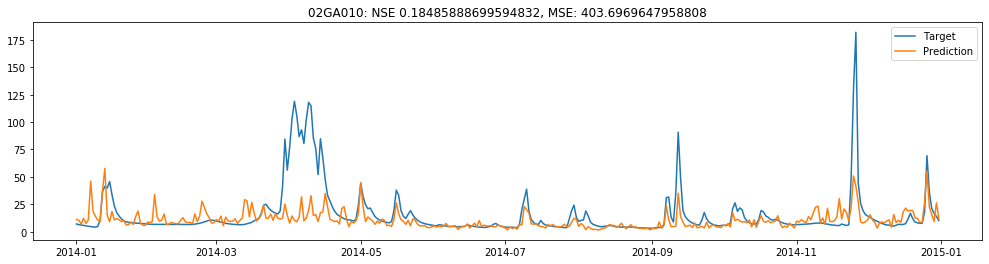

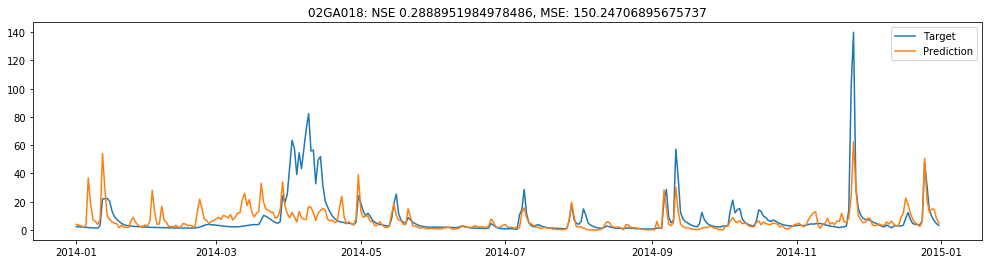

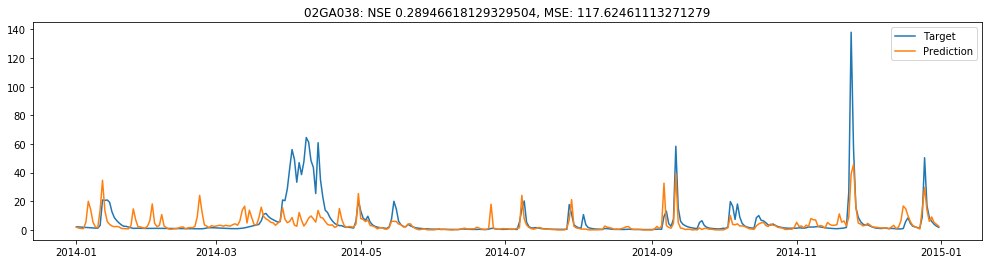

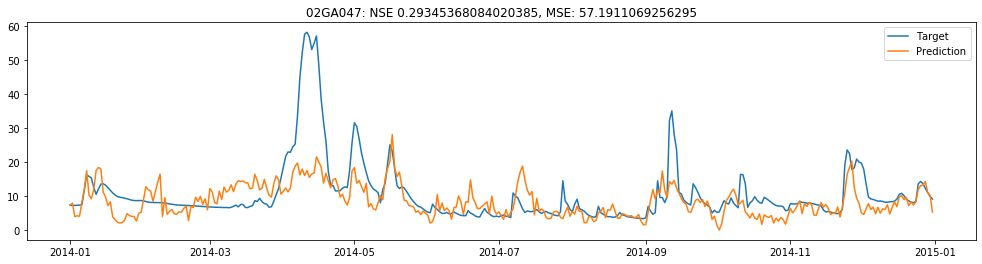

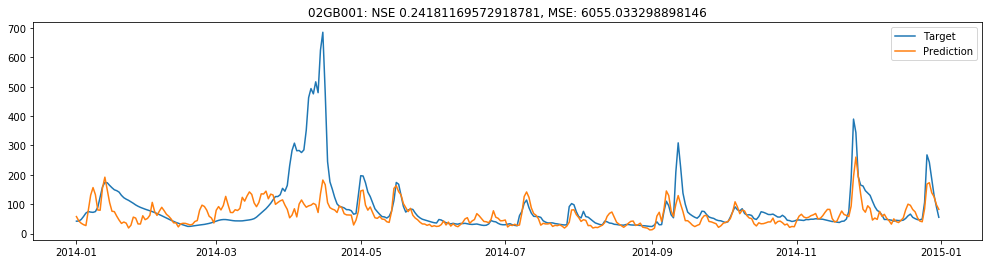

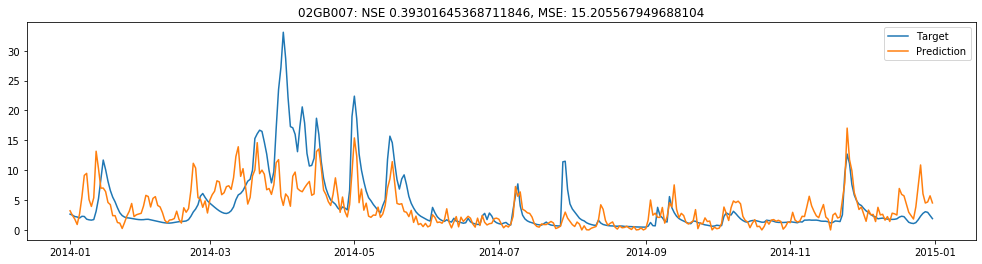

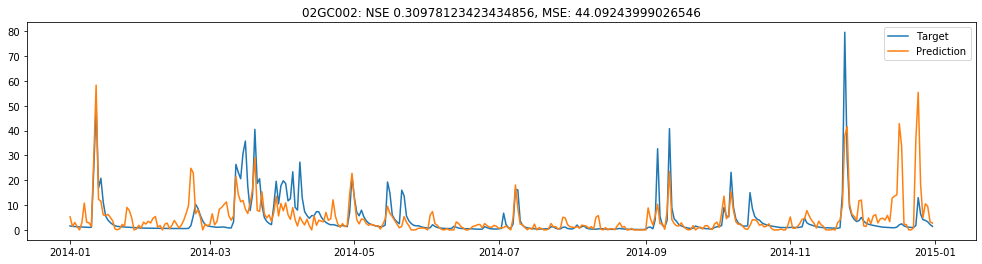

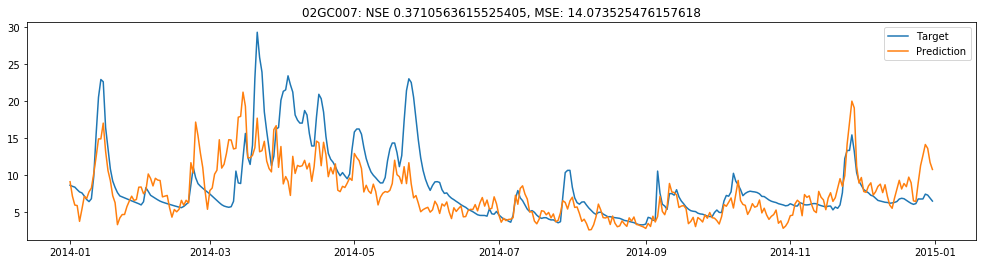

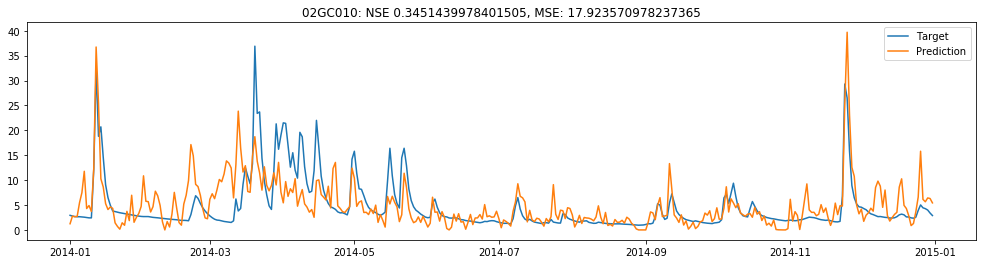

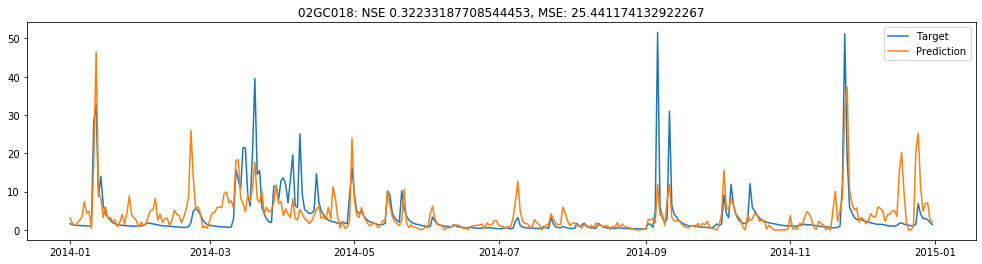

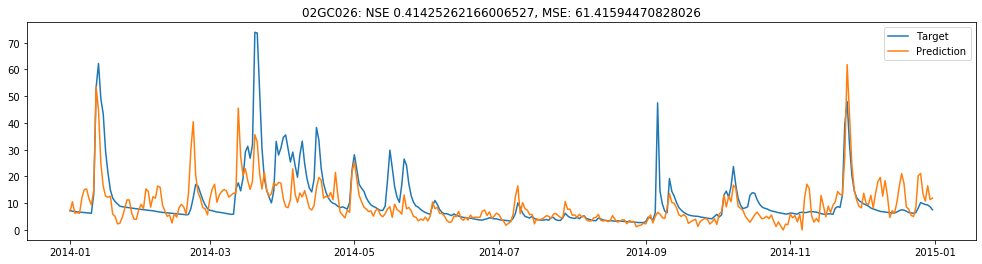

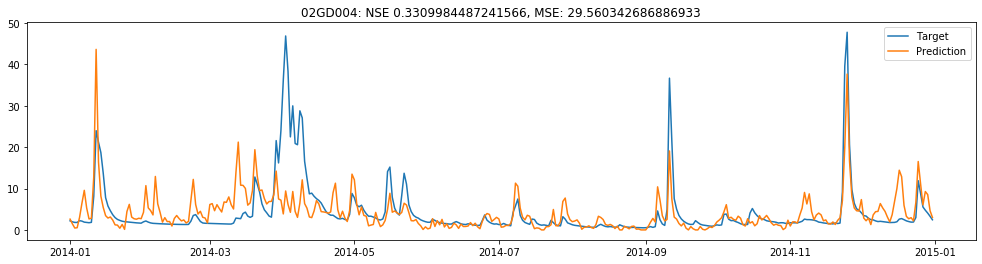

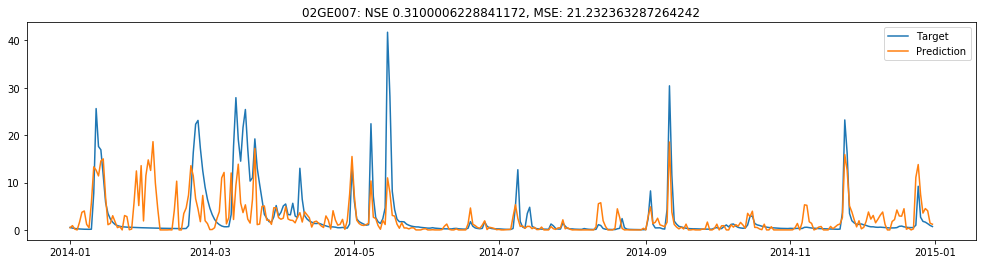

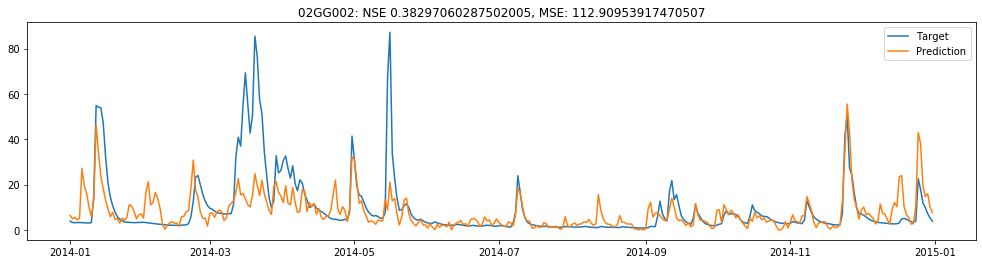

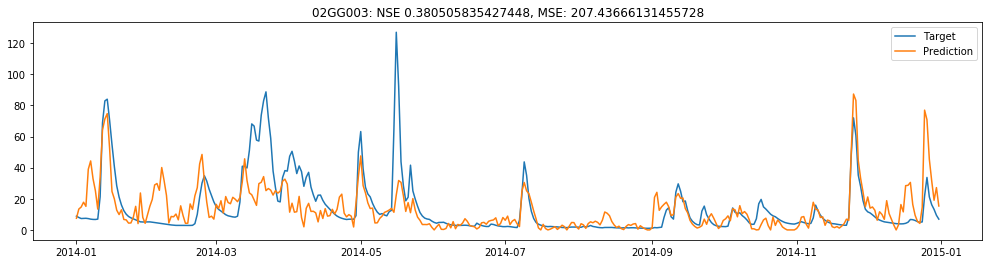

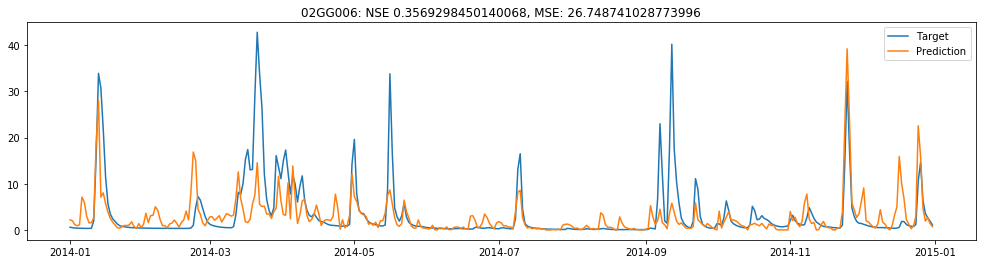

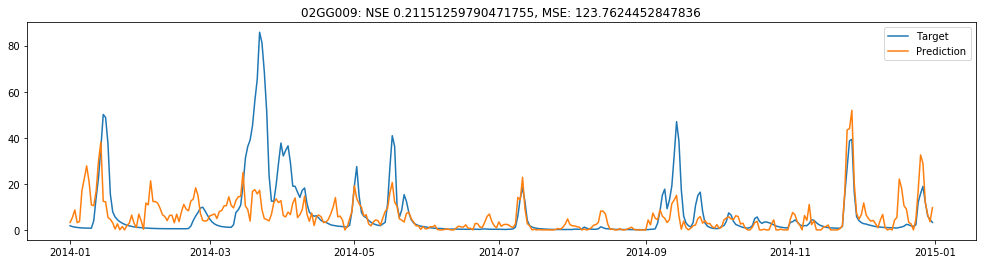

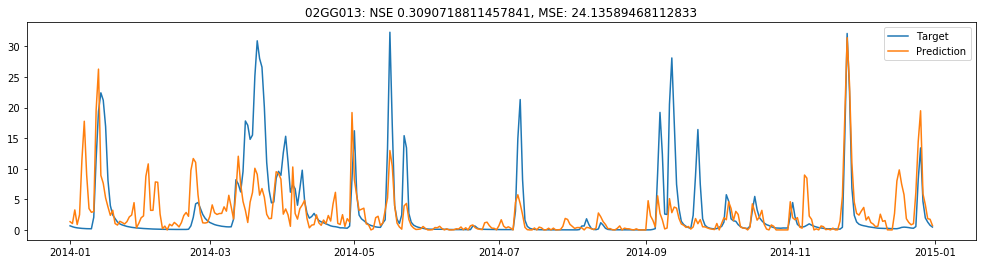

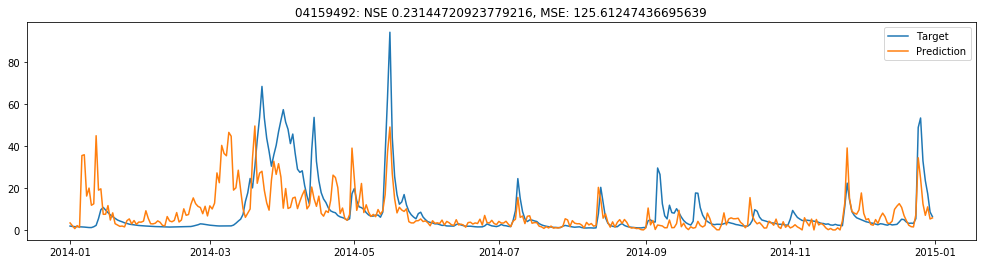

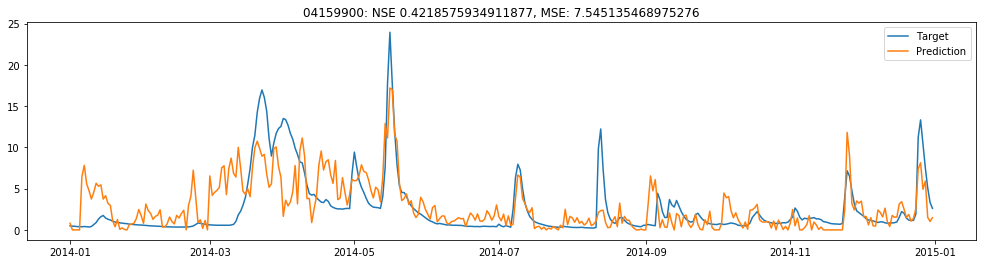

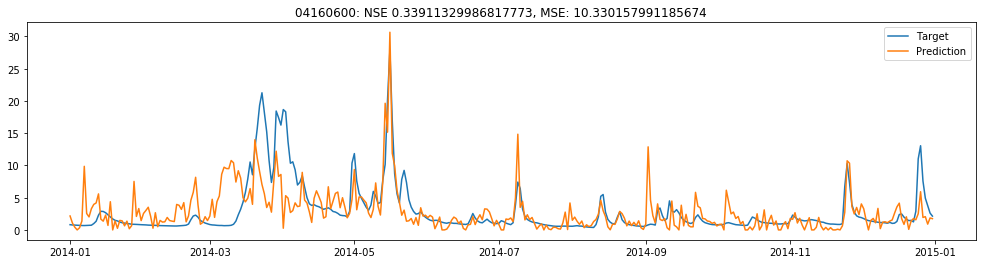

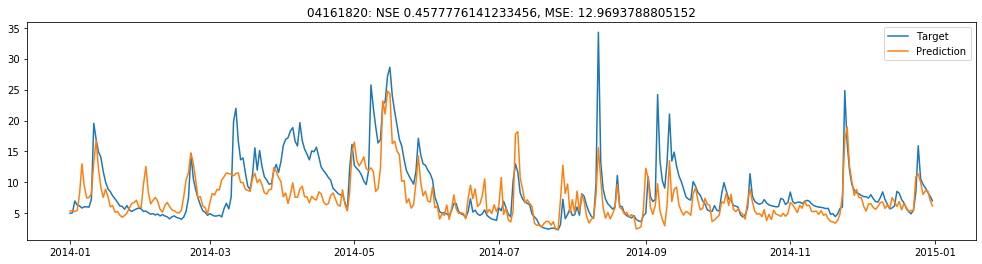

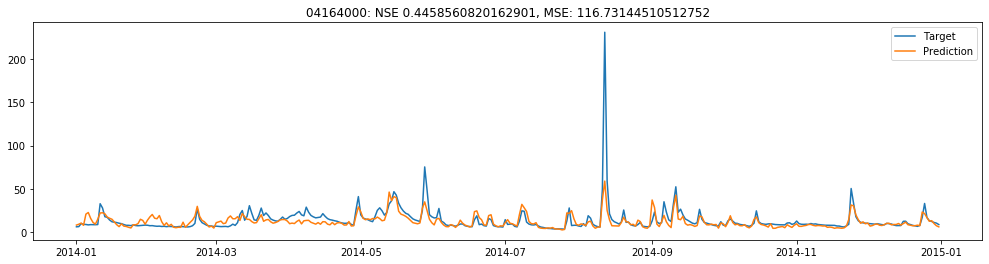

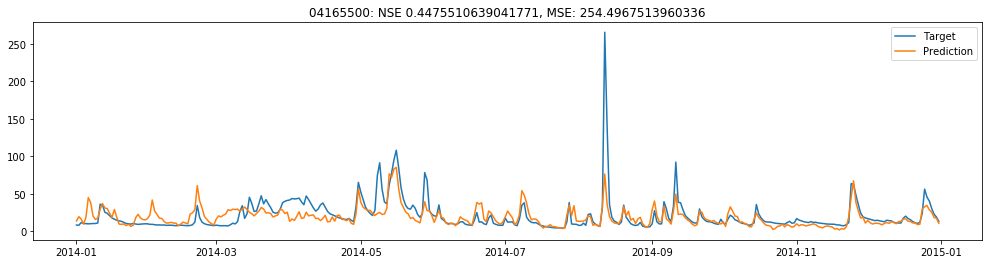

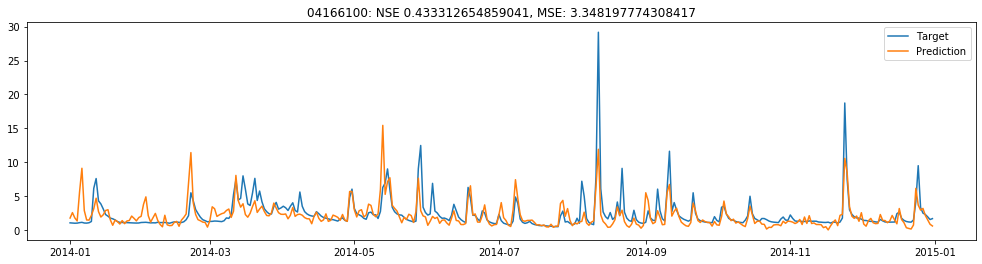

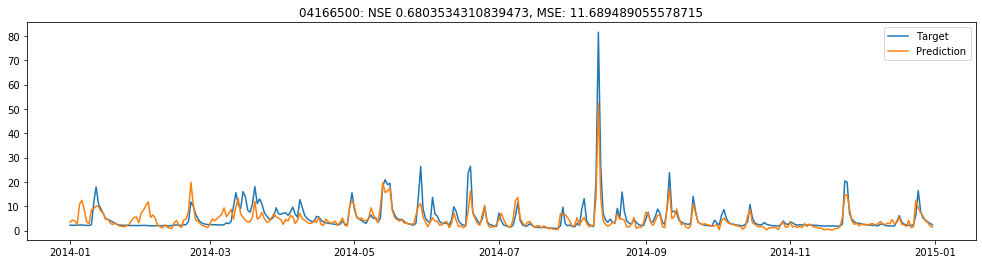

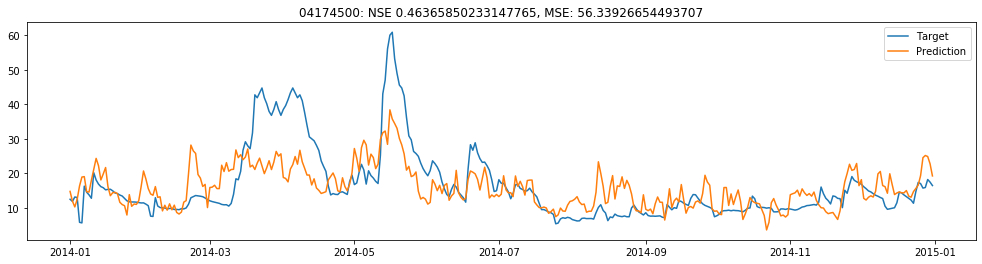

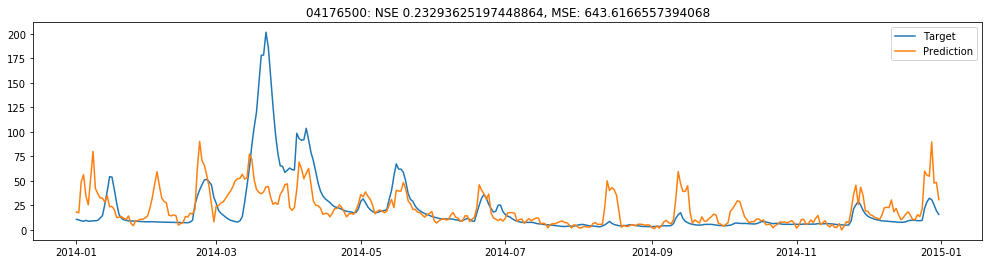

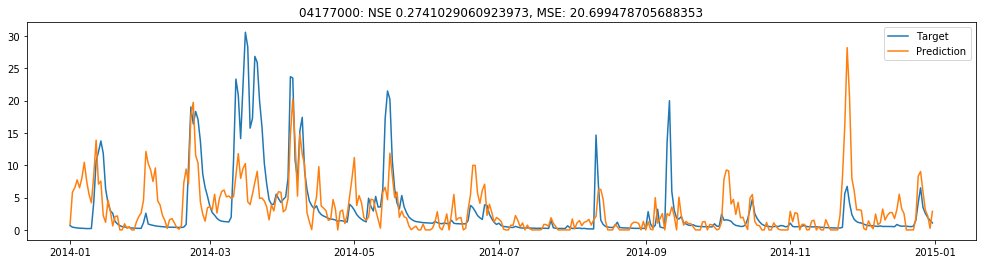

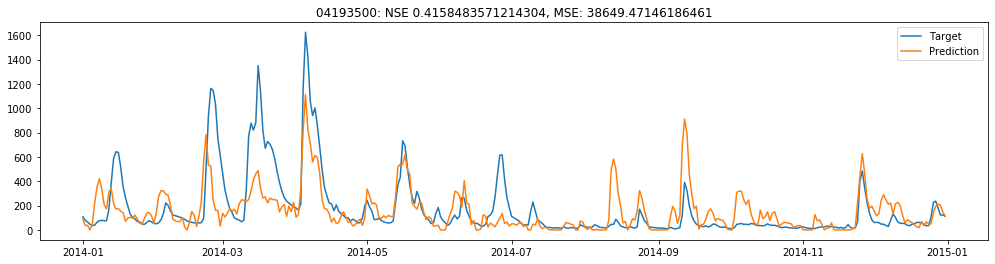

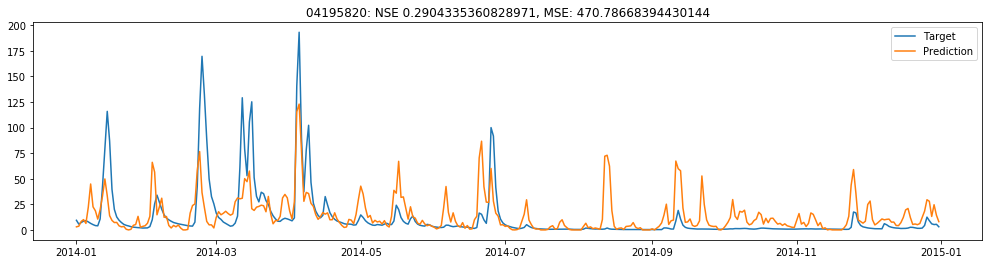

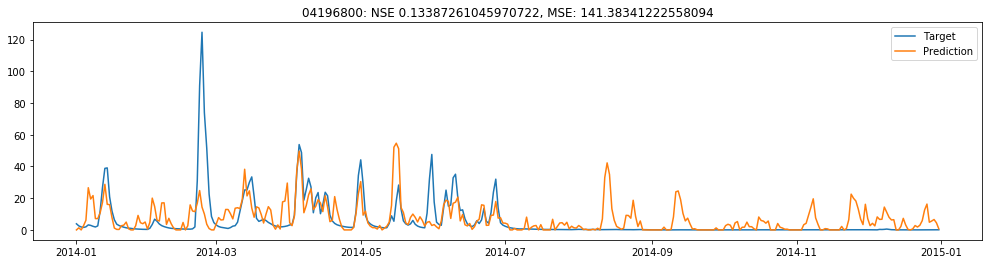

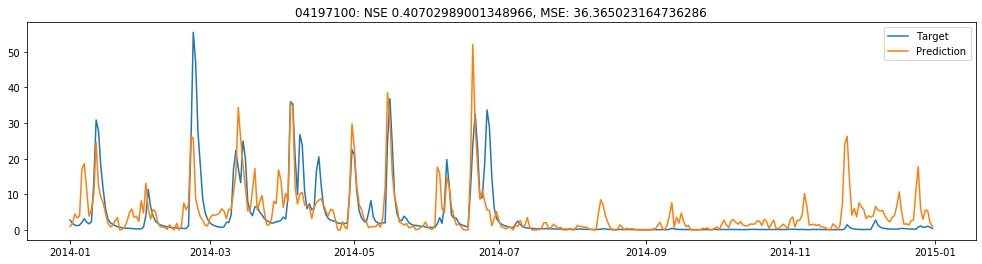

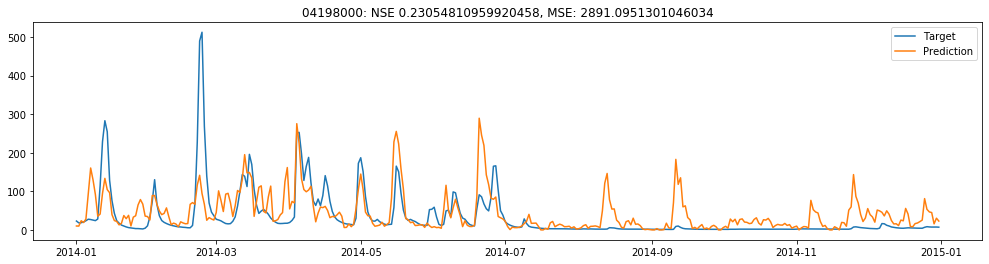

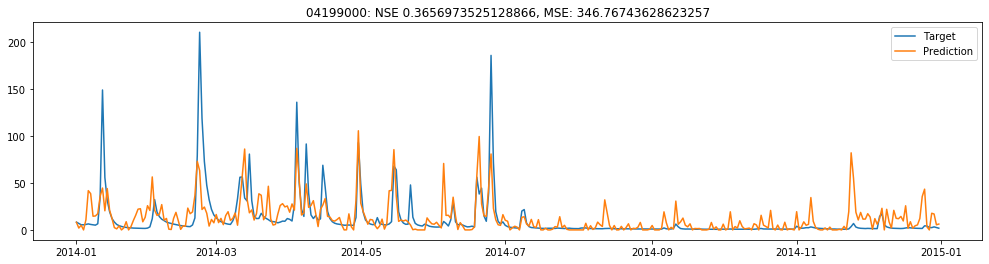

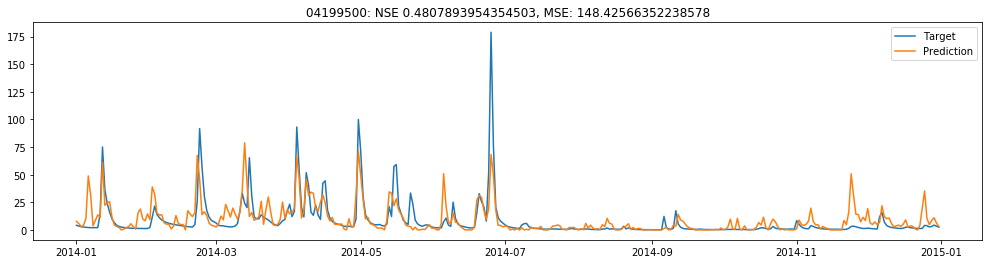

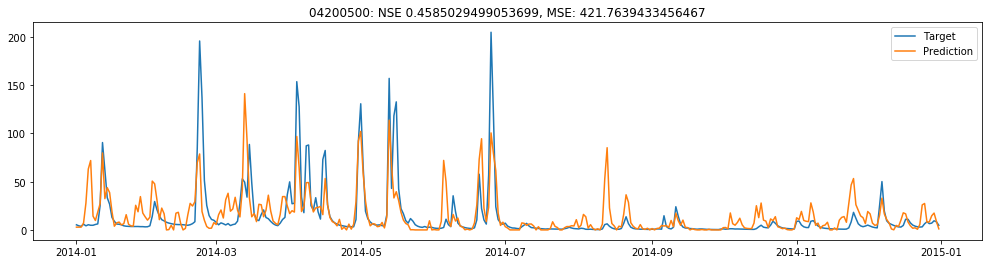

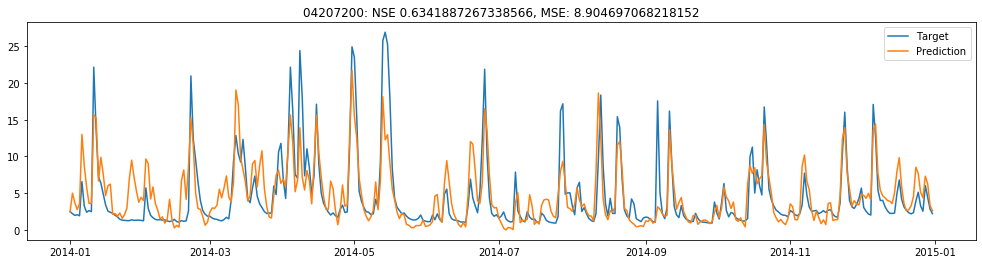

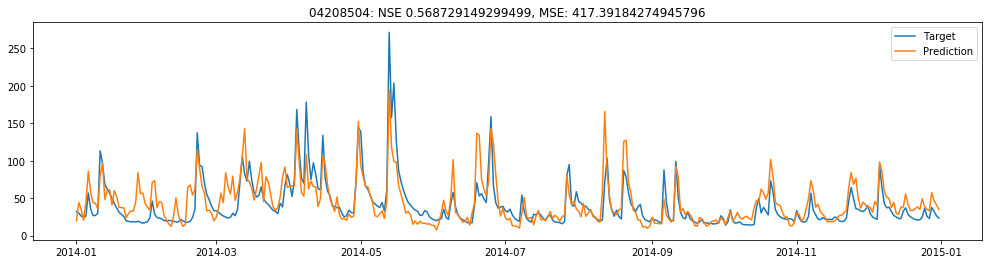

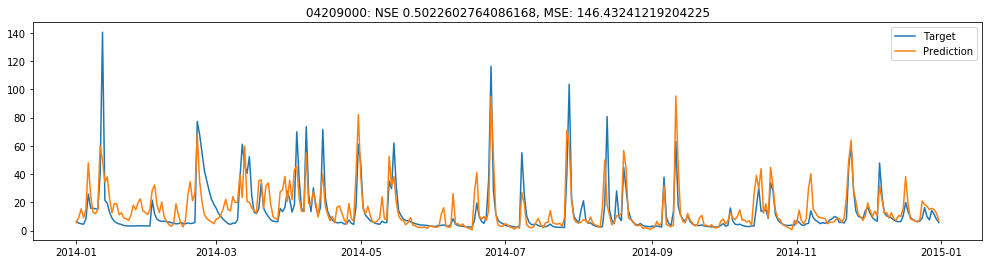

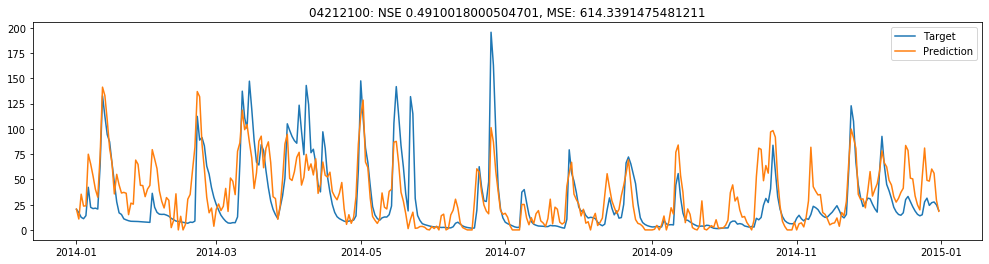

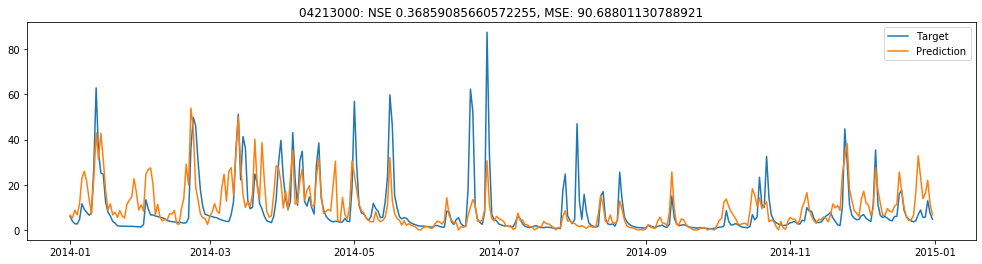

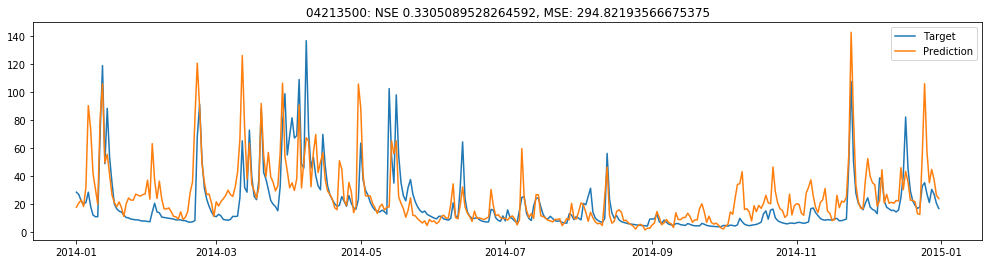

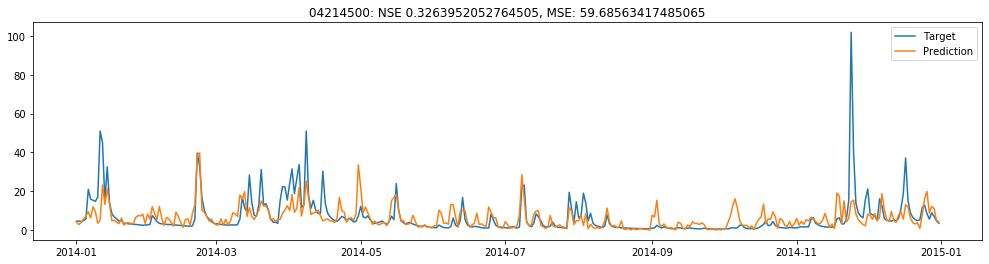

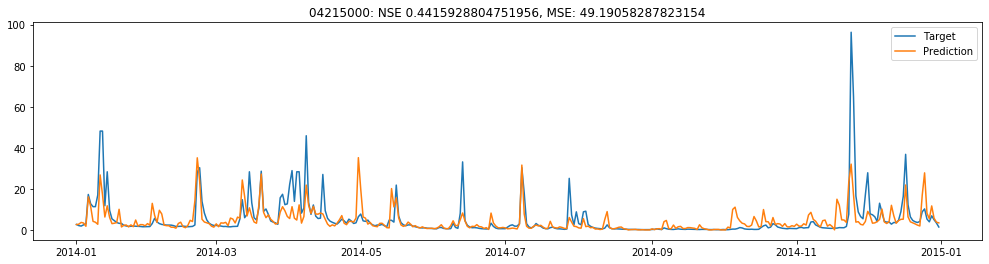

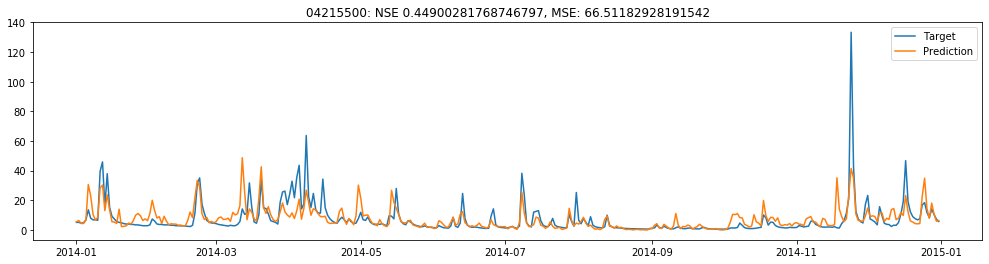

In [5]:
nse_list = []
mse_list = []
for station, predict in predictions.items():
    nse, mse = evaluate.evaluate_daily(station, predict, actuals[station], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [6]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings', (predictions, actuals), time_stamp)

'XGBoost_VIC_aggregateForcings_20190705-084937.pkl'

In [7]:
for station, model in models.items():
    load_data.pickle_model('XGBoost_VIC_aggregateForcings', model, station, time_stamp, model_type='sklearn')

Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA010_20190705-084937.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA018_20190705-084937.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA038_20190705-084937.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA047_20190705-084937.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GB001_20190705-084937.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GB007_20190705-084937.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC002_20190705-084937.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC007_20190705-084937.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC010_20190705-084937.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC018_20190705-084937.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC026_20190705-084937.pkl
Saved mode